# NPZD state estimation prototype

 * using a "stochastic" Ensemble Kalman filter

### model code

The cell below contains the model parameters and the NPZD model code, for use with a ordinary differential equation integrator, such as `spipy.integrate.odeint`. Note, that the parameter values in `parameters` act as constant reference values. For the trajectory of a typical model, see the [NPZD notebook](npzd.ipynb).

In [1]:
% parameter values
parameters = struct(...
    'vmax', 0.075, ...       % maximum growth rate in Michaelis Menten formulation
    'nuthalfsat', 0.3, ...   % nutrient half saturation in Michaelis Menten formulation
    'graz', 0.02, ...        % zooplankton grazing rate
    'mortP', 0.02, ...       % phytoplankton mortality rate
    'mortZ', 0.03, ...       % zooplankton mortality rate
    'reminrate', 0.1 ...     % remineralization rate
);


ans =

    '9.7.0.1296695 (R2019b) Update 4'



In [2]:
%%file npzd.m 
% the above line is required to create a matlab function inside a Jupyter notebook cell
function out = npzd(x, t, parameters, npzd_light)
    %{
    input
    =====
    x: model state
    t: current time (in days)
    parameters: model parameters
    light: light function returning irradiance at time t
    %}
    n = max(x(1), 0.0);
    p = max(x(2), 0.0);
    z = max(x(3), 0.0);
    d = max(x(4), 0.0);
    
    growth = parameters.('vmax') * n / (parameters.('nuthalfsat') + n) * npzd_light(t) * p;
    grazing = parameters.('graz') * p * z;
    p_loss = parameters.('mortP') * p;
    z_loss = parameters.('mortZ') * z * z;
    remin = parameters.('reminrate') * d;
    
    out = [-growth+remin, growth-grazing-p_loss, grazing-z_loss, p_loss+z_loss-remin];
end

Created file '/home/jmattern/projects/20220211_matlab_kernel/npzd.m'.


### code to run model

Helper functions for computing the light at time t (in units of days), which is a simple sinusoidal function, and running the NPZD model forward.
The time vector `t` determines the length of each NPZD model simulation.

In [3]:
%%file npzd_light.m
% light function returning irradiance at time t
function out = npzd_light(t)
    out =  1.0 + 0.5 * (0.8 * sin(pi * ((t - 81.25) / 182.5)) - 0.8);
end

Created file '/home/jmattern/projects/20220211_matlab_kernel/npzd_light.m'.


In [4]:
npzd_ode = @(t, x) npzd(x, t, parameters, @npzd_light)';

### settings changeable by the user

Parameters not listed in `parameters_reference` are assumed to be constant and kept at the values specified in `parameters` at the top of the notebook. Currently, the values in `parameters` for parameters that are being estimated, are used as the mean values for the prior ensemble. 

In [5]:
% true initial conditions (used to generate synthetic observations)
x0_true = [0.6, 0.15, 0.2, 0.05];

x0_prior = [0.2, 0.1, 0.3, 0.05];

% select the standard deviation of the prior ensemble for each
x0_prior_uncertainty = [0.1, 0.1, 0.1, 0.1];

% select when to observe state
t_obs = 10; % compare plot in NPZD notebook

% index of the state variables to observe
i_obs = [1, 2, 3]; % N, P, Z

% select the observation uncertainty
obs_uncertainty = [0.0003, 0.0003, 0.0003];

% select the number of ensemble members
n_ens = 50;

### code to generate synthetic data and create the ensembles

In [6]:
% number of observations
n_obs = length(i_obs);
n_x0 = length(x0_prior);

% use model to generate the synthetic data
% true_state is the true model state without any added noise
[t, trajectory] = ode45(npzd_ode, [0, t_obs], x0_true); %run_model(x0_true)[t_obs, i_obs];
true_state = trajectory(end, i_obs);

% generate ensemble of observations adding pseudo-random noise to true_state
Y = true_state' + obs_uncertainty' .* rand([n_obs, n_ens]);

% generate the prior ensemble of parameters X by adding pseud-random noise to the parameters 
X_mean = x0_prior;

X = max(0.0, X_mean' + x0_prior_uncertainty' .* rand([n_x0, n_ens]));

% for each initial condition in X, run the NPZD model to generate HX, the prior ensemble of model states 
% at the observations
HX = zeros([n_obs, n_ens]);
for iens = 1:n_ens
    [t, trajectory] = ode45(npzd_ode, [0, t_obs], X(:, iens));
    HX(:, iens) = trajectory(end, i_obs);
end

### code to perform data assimilation

Run the ensemble Kalman filter. Below, the symbold denote:

`HBHT`: $\mathbf{H}\mathbf{B}\mathbf{H}^T$

`BHT`: $\mathbf{B}\mathbf{H}^T$

`R`: $\mathbf{R}$

`K`: $\mathbf{B}\mathbf{H}^T \left(\mathbf{H}\mathbf{B}\mathbf{H}^T + \mathbf{R}\right)$ (Kalman gain)

In [7]:
HBHT = cov(HX');
BHT = (X-mean(X,2)) * (HX-mean(HX,2))' / (n_ens - 1);
R = diag(obs_uncertainty.^2);

K = BHT * inv(HBHT + R);

% use kalman gain to compute update for each ensemble member in X, and store updated ensemble in X_post
X_post = zeros(size(X));
for iens = 1:n_ens
    X_post(:, iens) = X(:, iens) + K * (Y(:,iens) - HX(:,iens));
end

In [8]:
%%file draw_ensemble.m 
function draw_ensemble(ensemble, color)
    
    ensmean = mean(ensemble, 2);
    enscov = cov(ensemble');

    a = enscov(1, 1);
    b = enscov(2, 1);
    c = enscov(2, 2);

    tmp = sqrt((0.5 * (a - c))^2 + b^2);
    l1 = sqrt(0.5 * (a + c) + tmp);
    l2 = sqrt(0.5 * (a + c) - tmp);

    if b == 0 and a >= c
        angle = 0;
    elseif b == 0 and a < c
        angle = 90;
    else
        angle = atan2(l1 - a, b) * 180 / pi;
    end
    
    beta = -angle * (pi / 180);
    sinbeta = sin(beta);
    cosbeta = cos(beta);

    alpha = linspace(0, 360, 200)' .* (pi / 180);
    sinalpha = sin(alpha);
    cosalpha = cos(alpha);

    x = ensmean(1) + (l1 * cosalpha * cosbeta - l2 * sinalpha * sinbeta);
    y = ensmean(2) + (l1 * cosalpha * sinbeta + l2 * sinalpha * cosbeta);
        
    plot(ensemble(1, :), ensemble(2, :), 'Marker', '.', 'MarkerEdgeColor', color, 'LineStyle', 'none')
    plot(ensmean(1), ensmean(2), 'Marker', '+', 'MarkerEdgeColor', color, 'LineStyle', 'none', ...
        'MarkerSize', 15)
    plot(x, y, color)
end

Created file '/home/jmattern/projects/20220211_matlab_kernel/draw_ensemble.m'.


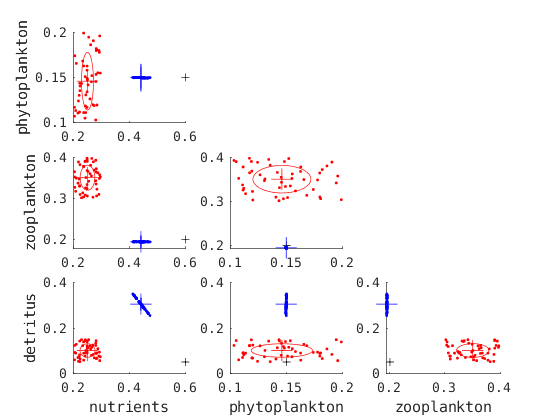

In [9]:
figure

nrows = n_x0 - 1;
ncols = n_x0 - 1;

state_names = {'nutrients', 'phytoplankton', 'zooplankton', 'detritus'};

for icol = 1:ncols
    for irow = 1:nrows
        subplot(nrows, ncols, (irow-1) * nrows + icol)
        if irow < icol
            set(gca(), 'Visible', 'off')
            continue
        end
        
        ix = icol;
        iy = irow + 1;
        
        hold on
        if irow == nrows
            xlabel(state_names{ix})
        end
        if icol == 1
            ylabel(state_names{iy})
        end
        plot(x0_true(ix), x0_true(iy), 'LineStyle', 'none', 'Marker', '+', 'MarkerEdgeColor', 'k')
        draw_ensemble(X([ix, iy], :), 'r')
        draw_ensemble(X_post([ix, iy], :), 'b')
        
    end
end